# Main Aggregation Script - calls lab.py and crystals.py

In [3]:
#Reloads the lab.py and crystals.py modules to update any changes (after saving)
#If a new method or object is created, autoreload doesn't work and the 
#kernel needs to be closed and halted after saving and making a 'checkpoint'
#in this notebook

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import ipas 
import numpy as np
import dask
from dask_jobqueue import SLURMCluster
from distributed import LocalCluster
from dask.distributed import Client, progress
from dask import delayed
from dask import dataframe as dd
import functools
import sys
import ast
from struct import *
import pickle
import glob
import random
import pandas as pd
import time
from dask.distributed import as_completed
from joblib import Parallel, delayed, parallel_backend
import matplotlib.pyplot as plt

In [5]:
cluster = SLURMCluster(
    queue='kratos',
    walltime='04-23:00:00',
    cores=1,
    memory='20000MiB', #1 GiB = 1,024 MiB
    processes=1)

#cluster.adapt(minimum=3, maximum=20)
cluster.scale(1)

/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [6]:
client = Client(cluster)

In [8]:
client

Client Scheduler: tcp://169.226.65.44:33695 Dashboard: http://169.226.65.44:42097/status,Cluster Workers: 1 Cores: 1 Memory: 20.97 GB


# Initialize databases for queries

In [10]:
files = ['sqlite:///'+f for f in glob.glob("db_files/IPAS_*_flat.sqlite")]
tables = ['aggregates', 'crystals']

In [11]:
%%time

df=[]
for table in tables:
    
    #read tables in parallel on client 
    read_files = [dask.delayed(dd.read_sql_table)(table=table, uri=file, index_col='id') for file in files]
    
    compute_read = client.compute(read_files)
    print('done with compute')
    ddfs = client.gather(compute_read)
    print('done with gather')
    #concatenate all sqlite files vertically (axis=0 default) (same columns)
    gathered_reads = client.scatter(ddfs)
    ddf = client.submit(dd.concat, gathered_reads).result()
    print('done with submit')
    #append combined dask df for each table
    df.append(ddf)


done with compute
done with gather
done with submit
done with compute
done with gather
done with submit
CPU times: user 8.49 s, sys: 1.13 s, total: 9.61 s
Wall time: 7min 38s


In [12]:
%time df_concat = dd.concat([df[0], df[1]], axis=1)

CPU times: user 2.98 ms, sys: 1.83 ms, total: 4.81 ms
Wall time: 5.1 ms


/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/dask/dataframe/multi.py:1055: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indexes of each dataframes are 
 aligned. This assumption is not generally safe.
  "Concatenating dataframes with unknown divisions.\n"


In [13]:
df_concat.agg_r = np.power((np.power(df_concat.a, 2) * df_concat.c), (1./3.))

In [14]:
def query_r_5000(df):
    return df[df.agg_r < 5000]

df_concat = df_concat.map_partitions(query_r_5000)
#len(df_concat) #86% of dataset

In [15]:
df_repart = df_concat.repartition(partition_size="100MB").persist()
df_repart.npartitions

58

# MAIN

In [16]:
ch_dist='gamma'         #anything other than gamma uses the characteristic from the best distribution pdf (lowest SSE)
rand_orient = False      #randomly orient the seed crystal and new crystal: uses first random orientation
save_plots = False     

In [17]:
def concatenate_points_all(agg):

    ncrystals = agg.ncrystals    
    #print('ncrystals', ncrystals)
    agg_id = agg.agg_id
    #print('ncrystals, phi, r, agg_id', ncrystals, agg_id, agg_id-ncrystals)
    
    query = df_repart[(df_repart.r == agg.r) & (df_repart.phi == agg.phi) & \
                     (df_repart.ncrystals >= 2) & (df_repart.ncrystals <= ncrystals) &\
                     (df_repart.agg_id <= agg_id) & (df_repart.agg_id >= agg_id-ncrystals)].compute()
    
    cluster = ipas.Cluster_Calculations(agg)
    hold_points = []
    for crys in query.itertuples():
        for points in pickle.loads(crys.points):
            hold_points.append(points)
        #print('hold points', hold_points)

    #cluster.points = np.concatenate(hold_points)
    cluster.points = np.reshape(hold_points, (int(np.shape(hold_points)[0]/12), 12))
    cluster.points = np.array(cluster.points, dtype=[('x', float), ('y', float), ('z', float)])        
        
#     points = np.concatenate(hold_points)
#     points = np.reshape(points, (int(np.shape(cluster.points)[0]/12), 12))
#     points = np.array(points, dtype=[('x', float), ('y', float), ('z', float)])    
  
    return cluster

In [18]:
def main():
    
    output = np.empty((mono_phi_bins,mono_r_bins,agg_phi_bins,agg_r_bins),dtype=object)
    hold_clusters  = np.empty((agg_phi_bins,agg_r_bins,nclusters), dtype=object)
    hold_monos = np.empty((mono_phi_bins,mono_r_bins,nclusters), dtype=object)
    
    for j in range(mono_phi_bins): 
        for k in range(mono_r_bins):   
            print('phio, r', phio_m[j],req_m[k])
            
            df_mono = df[1][(df[1].phi < phio_m[j]+(phio_m[j]*0.01)) &\
                            (df[1].phi > phio_m[j]-(phio_m[j]*0.01)) &\
                            (df[1].r < req_m[k]+(req_m[k]*0.01)) &\
                            (df[1].r > req_m[k]-(req_m[k]*0.01))].compute()

            samples_mono = df_mono.sample(nclusters)
            
            n_monos=0
            for mono in samples_mono.itertuples():
                mono = ipas.IceCrystal(mono)
                
                hold_monos[j,k,n_monos] = mono
                n_monos+=1
    
            res, phi_bins1 = pd.qcut(df_repart.agg_phi[df_repart.agg_phi<1.0].compute(), int(agg_phi_bins/2), retbins=True)
            res, phi_bins2 = pd.qcut(df_repart.agg_phi[df_repart.agg_phi>=1.0].compute(), int(agg_phi_bins/2), retbins=True)
            for i in range(int(agg_phi_bins/2)):
                phi_bins2=np.insert(phi_bins2,0,0)

            for i in range(agg_phi_bins):  #agg phi
                if i < int(agg_phi_bins/2): #skip the empty bin range surrounding phi=1.0
                    phi_bins = phi_bins1
                else:
                    phi_bins = phi_bins2

                print('phi_bin = ', phi_bins[i], phi_bins[i+1])
                #return a df that only queries within an aspect ratio bin
                df_phi = df_repart[(df_repart.agg_phi > phi_bins[i]) & (df_repart.agg_phi < phi_bins[i+1]) & \
                                   (df_repart.ncrystals > 2)]  
                #to ensure at least 2 crystals within agg since ncrystals=1 not in db
                #now break that aspect ratio bin into 20 equal r bins
                res, r_bins = pd.qcut(df_phi.agg_r.compute(), agg_r_bins, retbins=True)
                #print(r_bins)

                for r in range(agg_r_bins):   #agg r
                    print('j, k, i, r ', j, k, i, r)

                    #print('r = ', r_bins[r], r_bins[r+1])
                    df_r = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1]) & (df_phi.ncrystals > 2)].compute() 

                    #print(df_repart.id.value_counts().compute().head(30))         

                    start_time = time.time()

                    samples = df_r.sample(nclusters)

#                     start_time = time.time()
#                     n_aggs=0
#                     for agg in samples.itertuples():
#                         cluster = concatenate_points_all(agg)
#                         hold_clusters[i,r,n_aggs] = cluster
#                         n_aggs+=1
                    #print('time to concatenate all pts = ', (time.time()-start_time))

                    delayeds = []
                    for agg in samples.itertuples():
                        delayeds.append(dask.delayed(concatenate_points_all)(agg))
                    delayeds = client.compute(delayeds)
                    hold_clusters[i,r,:] = client.gather(delayeds)
                    #print('time to concatenate all pts = ', (time.time()-start_time))
                    
                    ipas.collect_clusters(hold_monos[j,k,:], hold_clusters[i,r,:], rand_orient=rand_orient)
                    #output[j,k,i,r] = dask.delayed(ipas.collect_clusters)(hold_monos[j,k,:],\
                    #                                                      hold_clusters[i,r,:], rand_orient=rand_orient)
    
    return output, hold_clusters
    

In [19]:
def compute():
    results = np.empty((mono_phi_bins, mono_r_bins, agg_phi_bins, agg_r_bins, nclusters))
    rxs = np.empty((mono_phi_bins, mono_r_bins, agg_phi_bins, agg_r_bins, nclusters))
    rys = np.empty((mono_phi_bins, mono_r_bins, agg_phi_bins, agg_r_bins, nclusters))
    rzs = np.empty((mono_phi_bins, mono_r_bins, agg_phi_bins, agg_r_bins, nclusters))
    phi2Ds = np.empty((mono_phi_bins, mono_r_bins, agg_phi_bins, agg_r_bins, nclusters))
    cplxs = np.empty((mono_phi_bins, mono_r_bins, agg_phi_bins, agg_r_bins, nclusters))
    dd = np.empty((mono_phi_bins, mono_r_bins, agg_phi_bins, agg_r_bins, nclusters))
    cluster1_ncrystals = np.empty((mono_phi_bins, mono_r_bins, agg_phi_bins, agg_r_bins, nclusters))
    
    start_time = time.time()
    for j in range(mono_phi_bins):
        for k in range(mono_r_bins):
            for i in range(agg_phi_bins):
                print('computing', j,k,i)
                gather = client.compute([*output[j,k,i,:]])  #only parallelizing agg r bins
                gather = client.gather(gather)
                gather = np.array(gather)
                rxs[j,k,i,:] = gather[:,0,:]
                rys[j,k,i,:] = gather[:,1,:]
                rzs[j,k,i,:] = gather[:,2,:]
                phi2Ds[j,k,i,:] = gather[:,3,:]
                cplxs[j,k,i,:] = gather[:,4,:] 
                dd[j,k,i,:] = gather[:,5,:]
                cluster1_ncrystals[j,k,i,:] = gather[:,6,:]

    print('time to collect = ', (time.time()-start_time))
    print('DONE!')
    print(np.shape(rxs))
    return rxs, rys, rzs, phi2Ds, cplxs, dd, cluster1_ncrystals

phio, r 1.2742749857031335 1
phi_bin =  0.006779258140958099 0.14532862094808147
j, k, i, r  0 0 0 0


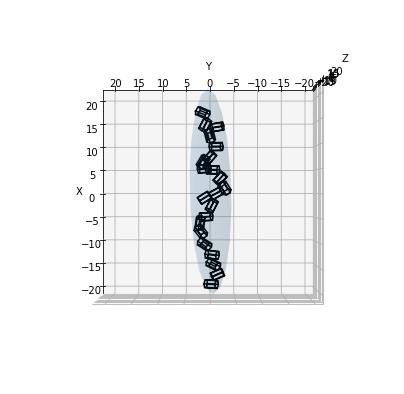

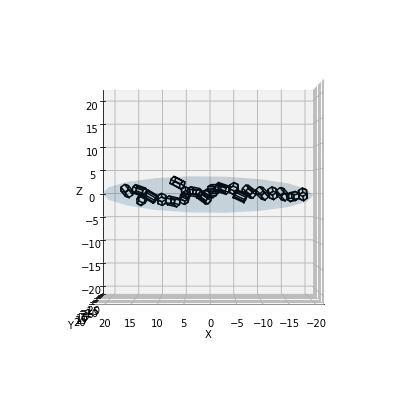

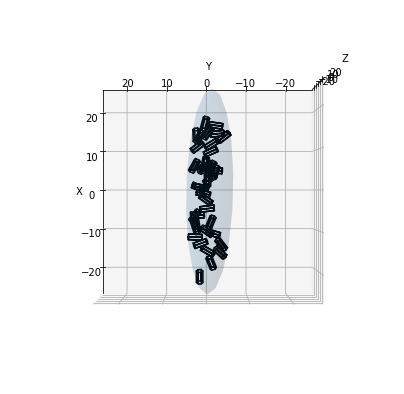

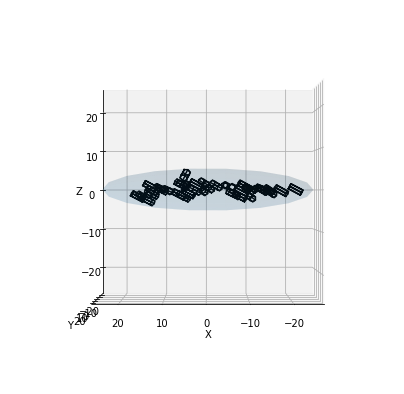

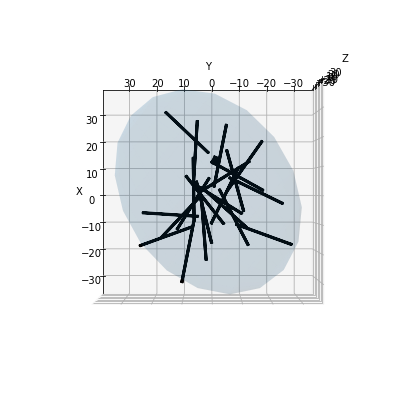

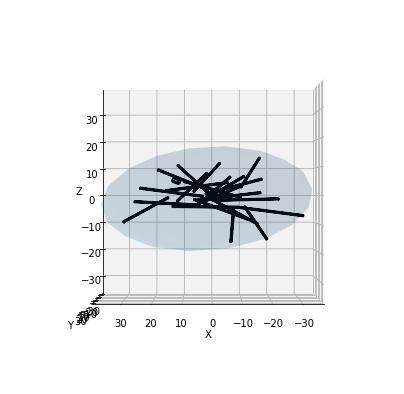

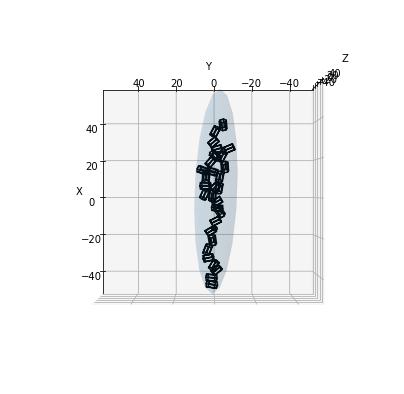

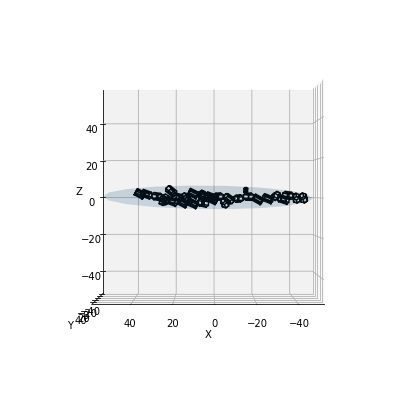

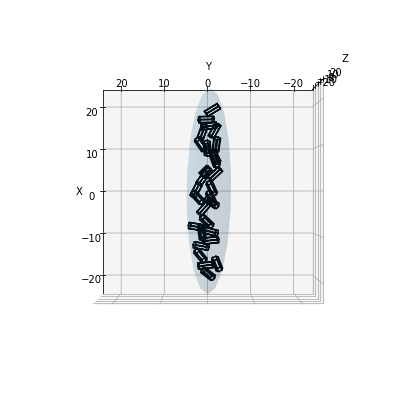

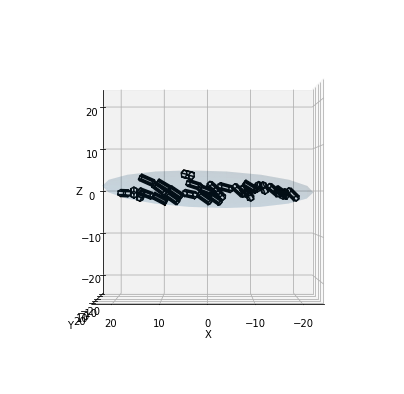

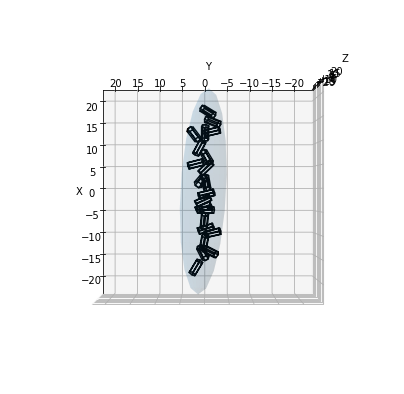

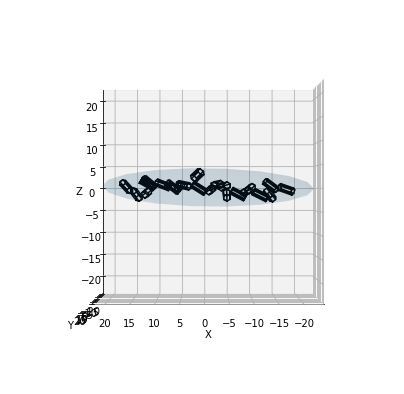

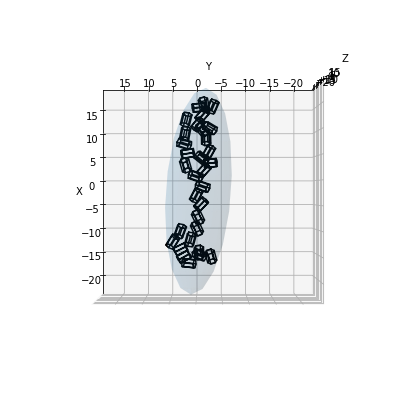

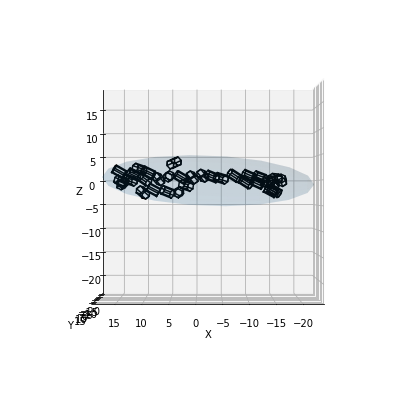

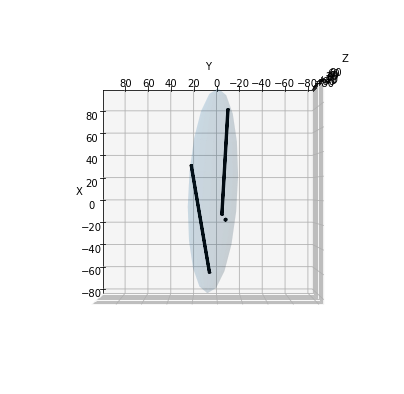

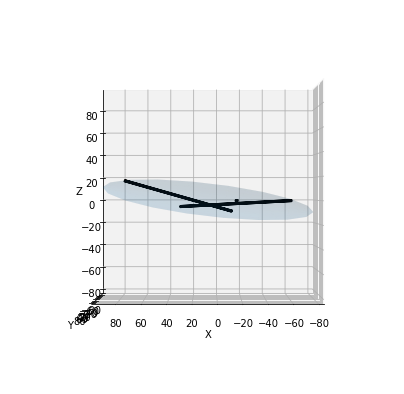

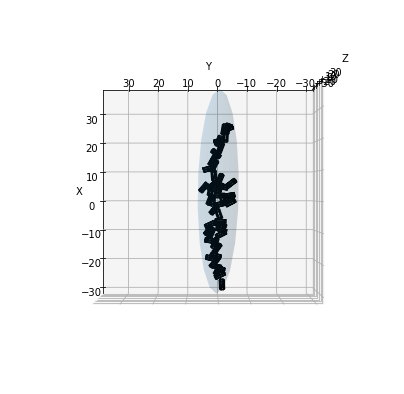

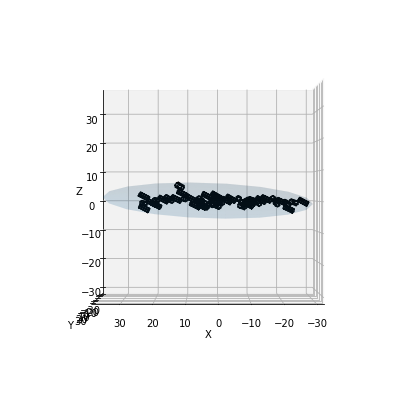

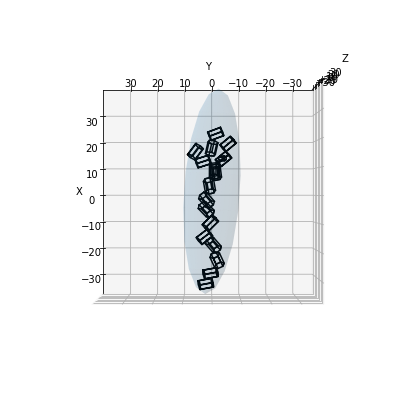

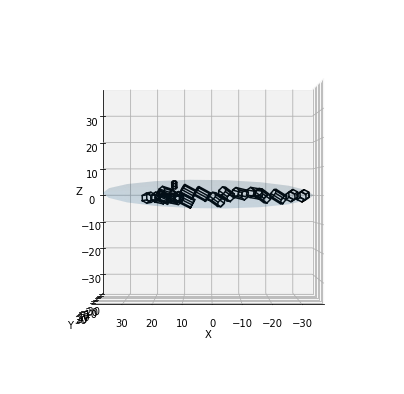

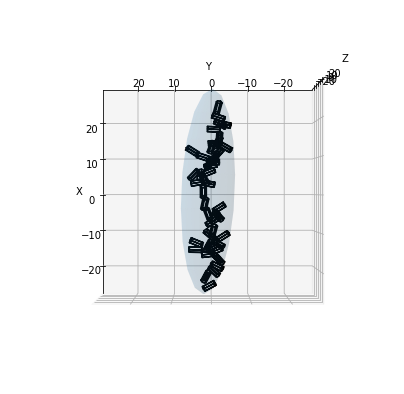

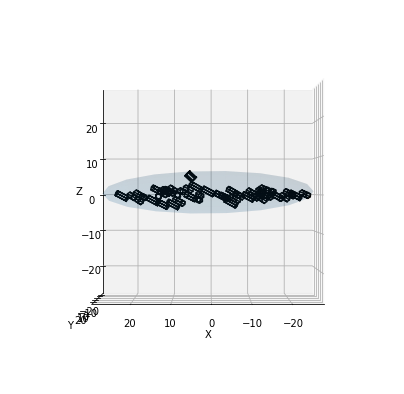

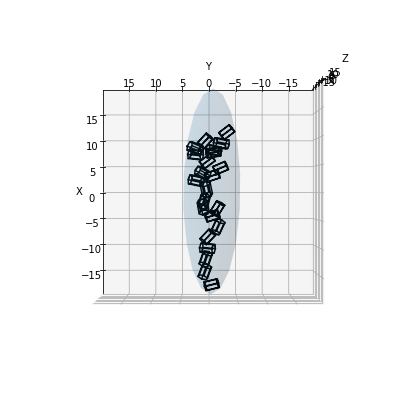

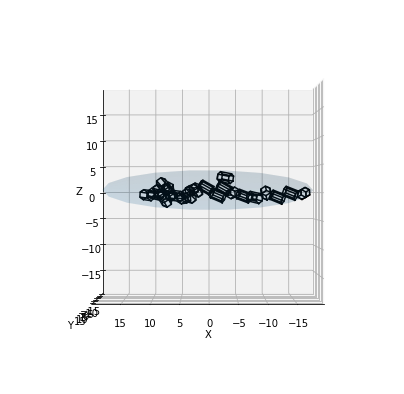

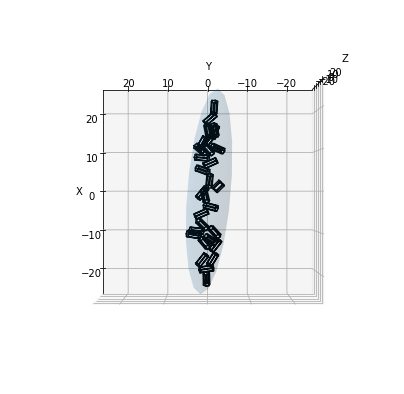

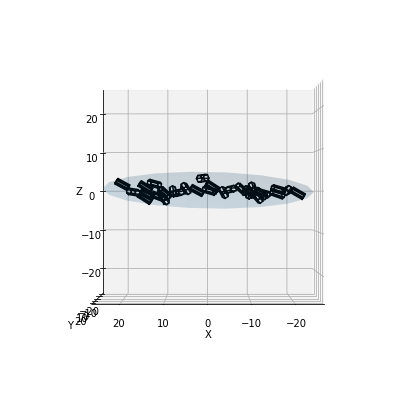

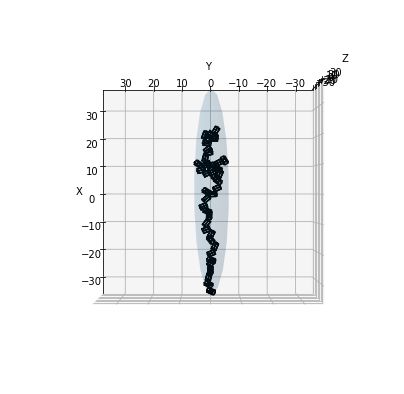

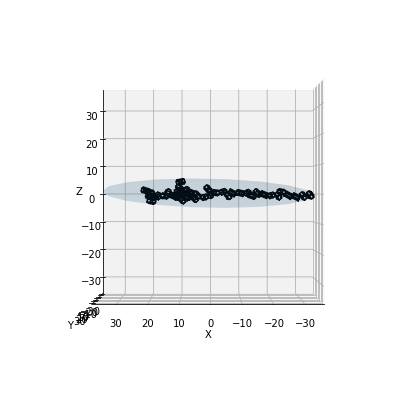

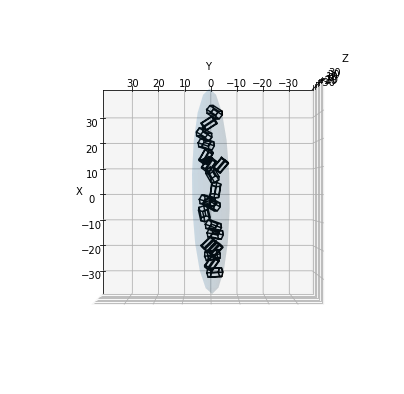

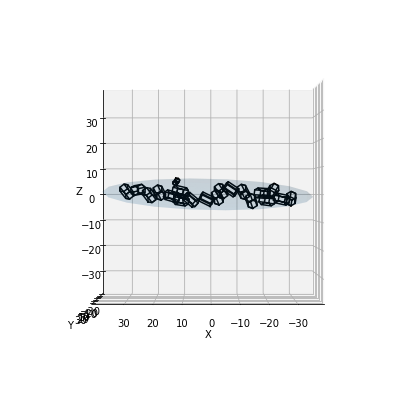

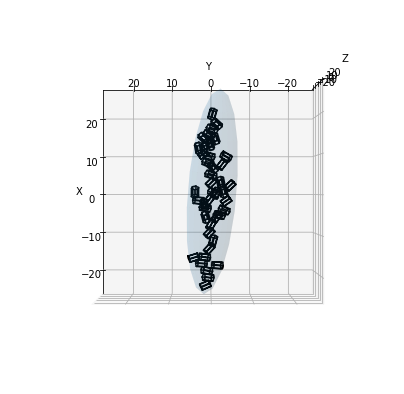

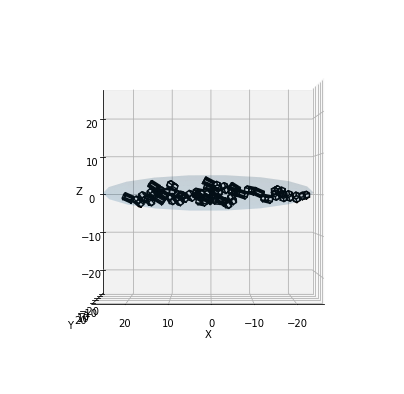

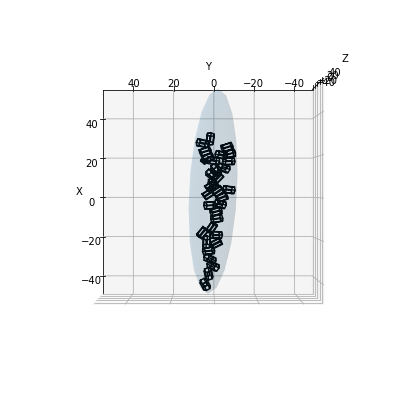

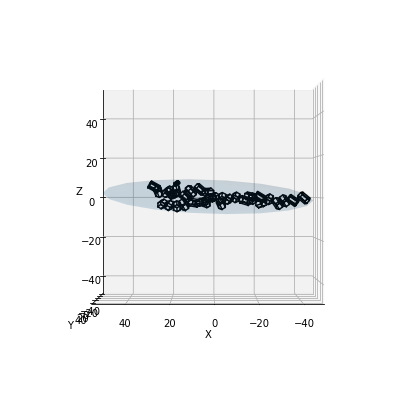

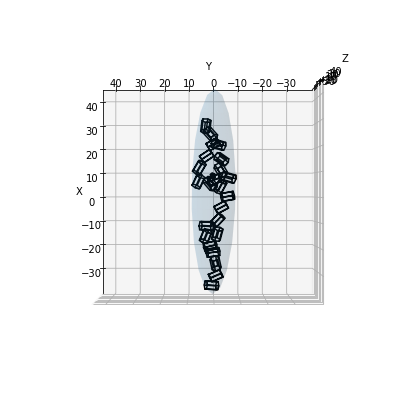

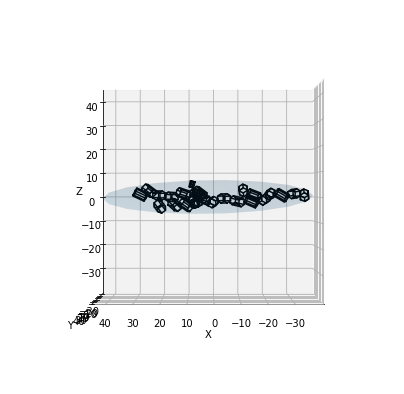

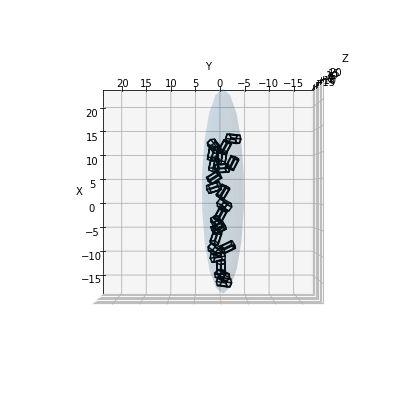

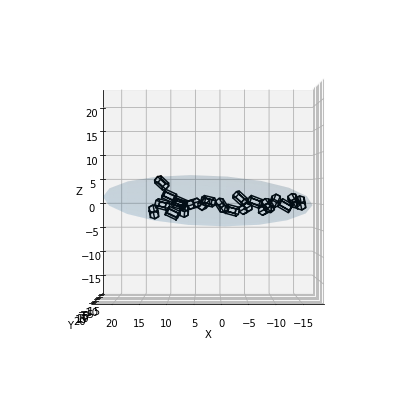

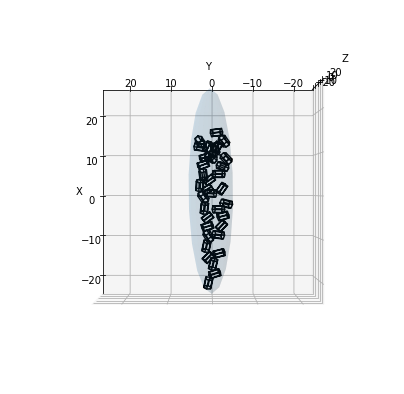

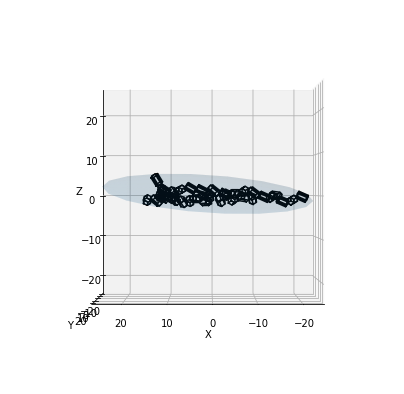

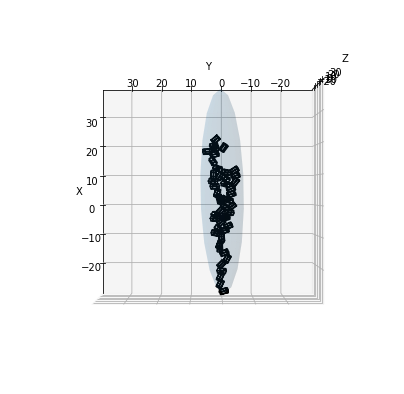

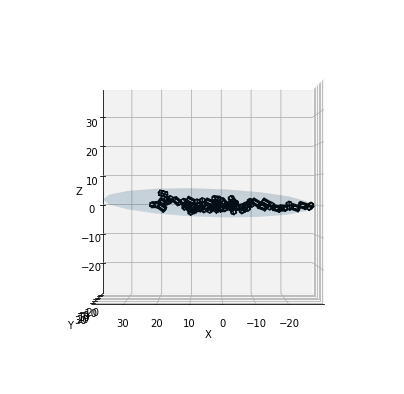

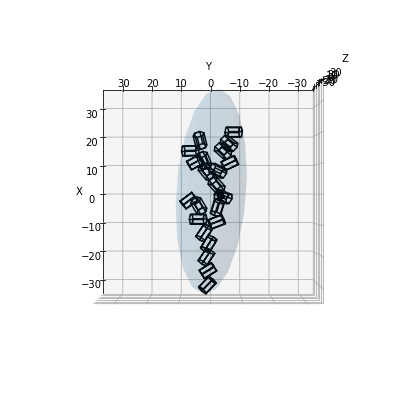

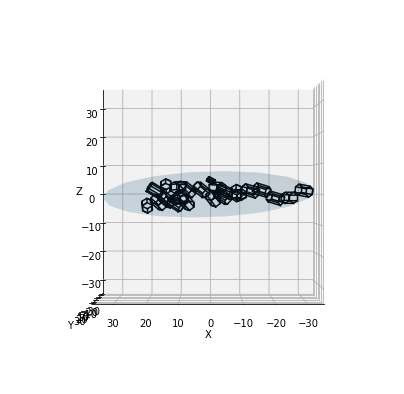

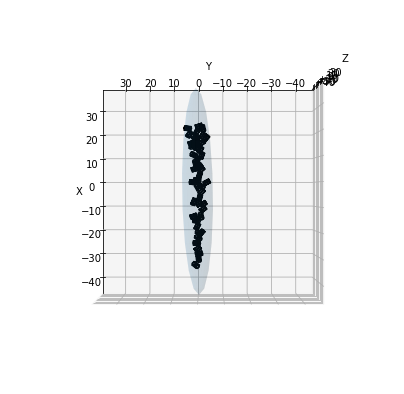

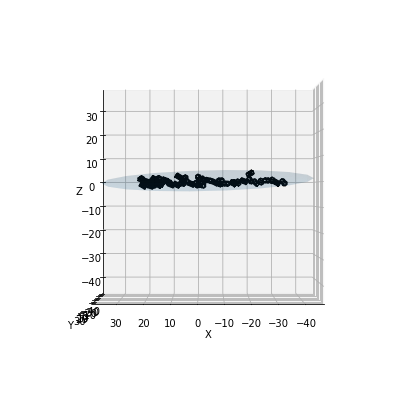

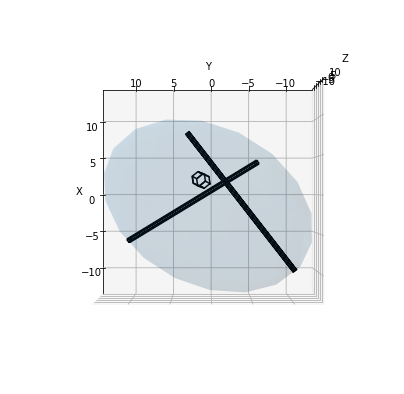

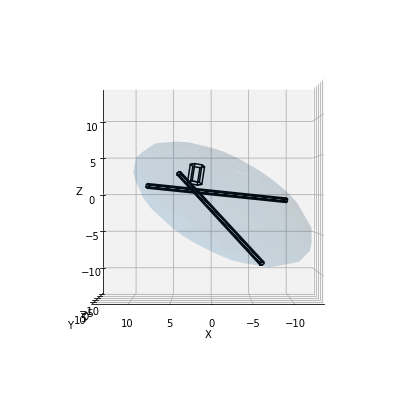

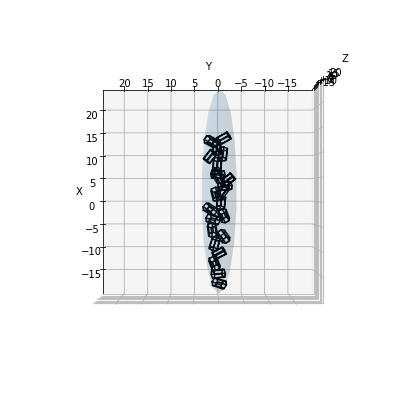

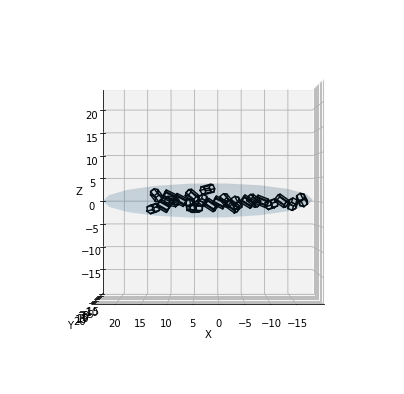

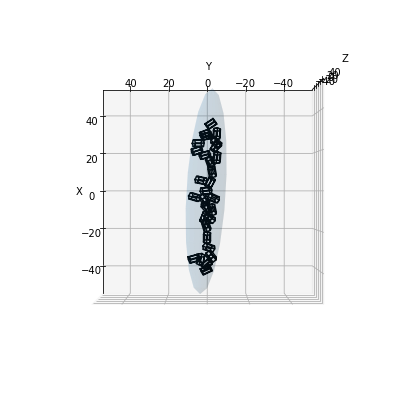

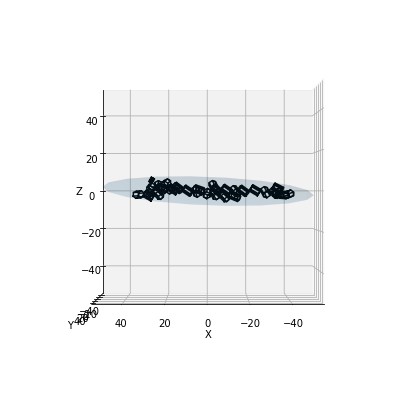

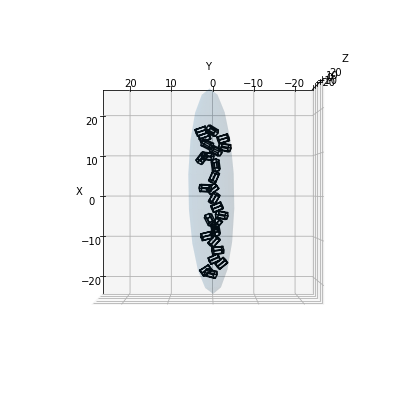

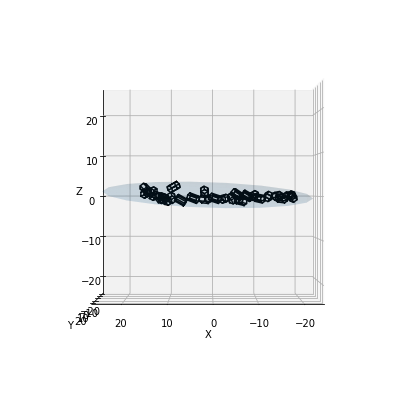

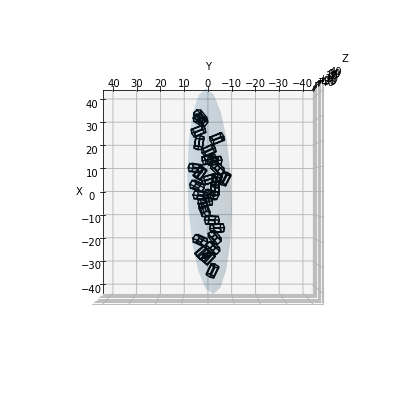

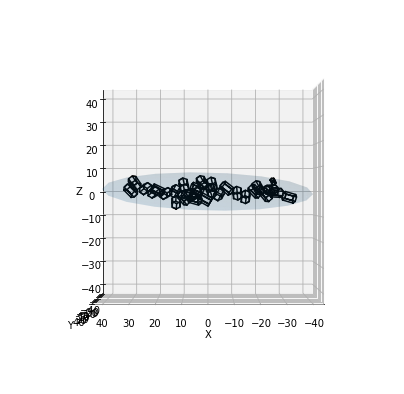

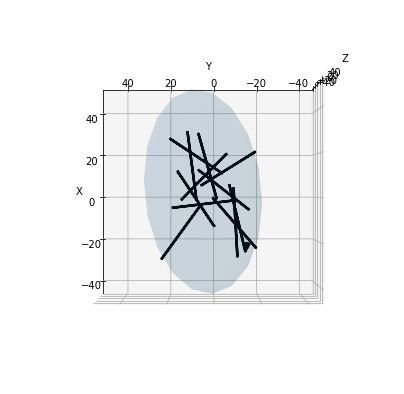

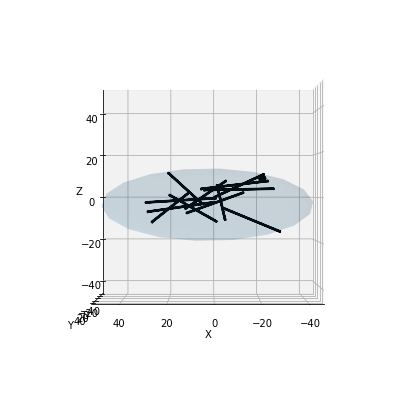

KeyboardInterrupt: 

In [25]:
if __name__ == '__main__':
    
    req_m = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,400,500,600,700,800,900,1000]

    agg_phi_bins = 20
    agg_r_bins = 20
    mono_phi_bins = 20
    mono_r_bins = len(req_m)
    nclusters = 300

    phio_m=np.logspace(-2, 2, num=mono_phi_bins, dtype=None)#just columns (0,2); plates (-2,0)

    output, hold_clusters = main()
    rxs, rys, rzs, phi2Ds, cplxs, dd, cluster1_ncrystals = compute()
    results = {'rxs': rxs, 'rys':rys, 'rzs':rzs, 'phi2Ds':phi2Ds, \
               'cplxs':cplxs, 'dd':dd, 'cluster1_ncrystals':cluster1_ncrystals}
   
    filename = 'instance_files/pulled_clusters_flat_iceagg'
    filehandler = open(filename, 'wb')
    pickle.dump(hold_clusters, filehandler)
    filehandler.close()
    print('finished!')
    
    filename = 'instance_files/instance_db_iceagg_flat'
    filehandler = open(filename, 'wb')
    pickle.dump(results, filehandler)
    filehandler.close()

In [119]:
df[1].r.value_counts().compute()

1000    294000
60      294000
2       294000
3       294000
4       294000
5       294000
6       294000
7       294000
10      294000
20      294000
30      294000
40      294000
900     294000
50      294000
70      294000
80      294000
90      294000
100     294000
400     294000
500     294000
600     294000
700     294000
800     294000
1       294000
200     291697
8       291691
300     210883
9       209682
Name: r, dtype: int64

In [151]:
from sqlalchemy.orm import sessionmaker
from sqlalchemy.engine import Engine
from sqlalchemy import create_engine, event, select
from sqlite3 import Connection as SQLite3Connection
from ipas import lab_ice_agg_createDB_bulkinsert as lab
from functools import partial

phioarr=np.logspace(-2, 2, num=10, dtype=None)#just columns (0,2); plates (-2,0)
lenphio = len(phioarr)

reqarr = [300]
numaspectratios=len(phioarr)
ch_dist='gamma'         #anything other than gamma uses the characteristic from the best distribution pdf (lowest SSE)
nclusters = 30        #changes how many aggregates per aspect ratio to consider
ncrystals = 50       #number of monomers per aggregate 1
minor = 'depth'        #'minorxy' from fit ellipse or 'depth' to mimic IPAS in IDL
rand_orient = True    #randomly orient the seed crystal and new crystal: uses first random orientation
save_plots = False     #saves all histograms to path with # of aggs and minor/depth folder
file_ext = 'eps'

def main():
    cluster = SLURMCluster(
    queue='kratos',
    walltime='04-23:00:00',
    cores=1,
    memory='20000MiB', #1 GiB = 1,024 MiB
    processes=1)

    cluster.scale(10)
    client = Client(cluster)
    time.sleep(30)
    print(client)
    
    notebook=8
    delayeds = []
    for r in reqarr:
        for phi in phioarr:
            parallel_clus=partial(lab.collect_clusters, notebook=notebook, r=r, nclusters=nclusters,\
                                  ncrystals=ncrystals,rand_orient=rand_orient)

            delayeds.append(dask.delayed(parallel_clus)(phi))
    print(delayeds)
    delayeds = client.compute(delayeds)
    list_of_clusters = client.gather(delayeds)
    client.close()
    return list_of_clusters


if __name__ == '__main__':
    startmain = time.time()
    list_of_clusters= main()

    endmain = time.time()
    print('time to complete all: ', endmain-startmain)


/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


<Client: 'tcp://169.226.65.44:40421' processes=10 threads=10, memory=209.70 GB>
[Delayed('collect_clusters-ae47e1a5-ec26-479c-af33-e19e20159e8e'), Delayed('collect_clusters-e58bd77f-3f9c-4f67-9e8b-45df66cf8293'), Delayed('collect_clusters-2245e6cd-5d4e-42cb-8608-1e6d12c823f1'), Delayed('collect_clusters-b59c10b1-cb12-4476-9f08-53ca53c53603'), Delayed('collect_clusters-d2daf472-7663-454b-830e-368c27fb5c5d'), Delayed('collect_clusters-0cdded31-c2c8-424d-82e6-5c058185fe6f'), Delayed('collect_clusters-3a0b8e02-b2ac-4feb-9707-0d28bdbd6a6a'), Delayed('collect_clusters-beb38112-7113-4917-9947-e4cc211fa861'), Delayed('collect_clusters-1de58291-3b9c-41dd-9bff-a706ef3c22c1'), Delayed('collect_clusters-761d2fba-3f01-470c-925d-d277a877e06a')]
time to complete all:  1668.6030900478363


In [ ]:
def _set_sqlite_pragma(dbapi_connection, connection_record):
    if isinstance(dbapi_connection, SQLite3Connection):
        cursor = dbapi_connection.cursor()
        cursor.execute("PRAGMA foreign_keys=ON;")
        cursor.execute("PRAGMA synchronous=0")
        cursor.execute("PRAGMA jounal_mode=MEMORY")
        #cursor.execute("PRAGMA journal_mode=WAL;")
        cursor.close()


engine = create_engine('sqlite:///db_files/test_%d_%d_%.3f_lastmono.sqlite' %(notebook, r, phio))
event.listen(engine, 'connect', _set_sqlite_pragma)
ipas.base.Base.metadata.create_all(engine, checkfirst=True)
Session = sessionmaker(bind=engine)
session = Session()
    
start = time.time()
session.add_all(list_of_clusters)
session.commit()
end = time.time()
time_taken = end - start
print('time to commit in bulk: ', time_taken)
 

In [163]:
from distributed import Client, LocalCluster
import subprocess
import os

import pdb

def get_procs():
   pid = os.getpid()
   return subprocess.check_output([ "lsof", '-w', '-Ff', "-p", str( pid ) ] ).splitlines()

def get_new_procs(orig):
   return [proc for proc in get_procs() if proc not in orig]

if __name__ == '__main__':
   pid = os.getpid()

   procs0 = set(get_procs())

   print("baseline", procs0)

   
   for i in range(1000):
       print("step", i)

       # pdb.set_trace()
       cluster = LocalCluster()
       client = Client(cluster)
       procs = get_new_procs(procs0)
       print("after LocalCluster :: new open count %d, procs "%len(procs))

       client.close()

       procs = get_new_procs(procs0)
       print("after close :: leaked count %d, procs "%len(procs)) # , procs)
   cluster.close()

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://169.226.65.44:40360 remote=tcp://169.226.65.44:44639>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://169.226.65.44:40362 remote=tcp://169.226.65.44:44639>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://169.226.65.44:49000 remote=tcp://169.226.65.44:35007>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://169.226.65.44:49002 remote=tcp://169.226.65.44:35007>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://169.226.65.44:40364 remote=tcp://169.226.65.44:44639>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://169.226.65.44:49012 remote=tcp://169.226.65.44:35007>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://169.226.65.44:49014 remote=tcp://169.226.65.44:35007>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp:

Traceback (most recent call last):
  File "/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-163-5863b39c3526>", line 17, in <module>
    procs0 = set(get_procs())
  File "<ipython-input-163-5863b39c3526>", line 9, in get_procs
    return subprocess.check_output([ "lsof", '-w', '-Ff', "-p", str( pid ) ] ).splitlines()
  File "/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/subprocess.py", line 336, in check_output
    **kwargs).stdout
  File "/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/subprocess.py", line 403, in run
    with Popen(*popenargs, **kwargs) as process:
  File "/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/subprocess.py", line 709, in __init__
    restore_signals, start_new_session)
  File "/network/rit/lab/sulialab/share/bi

KeyboardInterrupt: 

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://169.226.65.44:40488 remote=tcp://169.226.65.44:44639>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://169.226.65.44:49136 remote=tcp://169.226.65.44:35007>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://169.226.65.44:40492 remote=tcp://169.226.65.44:44639>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://169.226.65.44:49140 remote=tcp://169.226.65.44:35007>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://169.226.65.44:49142 remote=tcp://169.226.65.44:35007>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://169.226.65.44:40498 remote=tcp://169.226.65.44:44639>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://169.226.65.44:40500 remote=tcp://169.226.65.44:44639>
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING 